# Imports:

In [2]:
from connect import *

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jfcevallos. Use `wandb login --relogin` to force relogin


In [3]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from torchvision.models import resnet18

In [5]:
import NAR.utils as utils
import NAR.data_management as dm
import NAR.plotting_utils as pu
import NAR.masking as masking
import NAR.models as models

# Reload modules (DEV):

In [6]:
reload_modules([utils, dm, pu, masking, models])

reloading module :<module 'NAR.utils' from '/home/jovyan/NIDS/NERO2/NAR/utils.py'>
reloading module :<module 'NAR.data_management' from '/home/jovyan/NIDS/NERO2/NAR/data_management.py'>
reloading module :<module 'NAR.plotting_utils' from '/home/jovyan/NIDS/NERO2/NAR/plotting_utils.py'>
reloading module :<module 'NAR.masking' from '/home/jovyan/NIDS/NERO2/NAR/masking.py'>
reloading module :<module 'NAR.models' from '/home/jovyan/NIDS/NERO2/NAR/models.py'>


# Checkpoint:

In [7]:
WORKSPACE_DIR = '/home/jovyan/shared/jesus/datasets/'
# !tar -xzvf {datafile} -C {WORKSPACE_DIR}
datadir = WORKSPACE_DIR + 'BoT_IoT_imgs'

data = utils.init_bot_iot_ds_from_dir(datadir)


micro_zdas = [
        'DDoS_TCP',           # Type B
        'DDoS_HTTP',          # Type B
        'XSS',                # Type B
        'MITM',               # Type A
        'DoS_HTTP',           # Type B
        'DoS_UDP',            # Type B
        'Ransomware',         # Type B
        'Scan_Service',       # Type A
        'Scan_OS'             # Type A
        ]

micro_type_A_ZdAs = [
        'MITM',   # Type A
        'Scan_Service',       # Type A
        'Scan_OS'             # Type A
]

micro_type_B_ZdAs = [
        'DDoS_TCP',           # Type B
        'DDoS_HTTP',          # Type B
        'DoS_HTTP',           # Type B
        'DoS_UDP',            # Type B
        'XSS',                # Type B
        'Ransomware',         # Type B

]

train_type_B_micro_classes = [
            'DDoS_TCP',       # Type B
            'XSS',            # Type B
            'DoS_UDP',            # Type B
            ]

test_type_B_micro_classes = [
            'DoS_HTTP',       # Type B
            'Ransomware',     # Type B
            'DDoS_HTTP',          # Type B
            ]


test_type_A_macro_classes = [
            'MITM'            # Type A
            ]

train_type_A_macro_classes = [
            'Scan'           # Type A
            ]

data = masking.mask_real_data(
    data=data,
    micro_zdas=micro_zdas,
    micro_type_A_ZdAs=micro_type_A_ZdAs,
    micro_type_B_ZdAs=micro_type_B_ZdAs
    )

train_data, test_data = masking.split_real_data(
    data,
    train_type_B_micro_classes,
    test_type_B_micro_classes,
    test_type_A_macro_classes,
    train_type_A_macro_classes
    )

micro_classes = data['Micro Label'].unique()
macro_classes = data['Macro Label'].unique()

Micro classes ['Backdoor' 'DDoS_HTTP' 'DDoS_TCP' 'DDoS_UDP' 'Data_Exfiltration'
 'DoS_HTTP' 'DoS_TCP' 'DoS_UDP' 'MITM' 'Password' 'Ransomware'
 'SQLInjection' 'Scan_OS' 'Scan_Service' 'Theft_Keylogging' 'Uploading'
 'XSS']

Micro type A ZdAs ['Scan_OS' 'Scan_Service' 'MITM']

Micro type B ZdAs ['DDoS_HTTP' 'DDoS_TCP' 'DoS_HTTP' 'DoS_UDP' 'XSS' 'Ransomware']


Known micro classes ['SQLInjection' 'Backdoor' 'Data_Exfiltration' 'Theft_Keylogging'
 'Uploading' 'Password' 'DDoS_UDP' 'DoS_TCP']

test_type_A_macro_classes ['MITM']

train_type_A_macro_classes ['Scan']

test_type_B_micro_classes ['DoS_HTTP', 'Ransomware', 'DDoS_HTTP']

train_type_B_micro_classes ['DDoS_TCP', 'XSS', 'DoS_UDP']



In [8]:
print('Train Type A ZdAs: \n', train_data[train_data.Type_A_ZdA]['Micro Label'].unique())
print('Train Type B ZdAs: \n', train_data[train_data.Type_B_ZdA]['Micro Label'].unique())
print('Test Type A ZdAs: \n', test_data[test_data.Type_A_ZdA]['Micro Label'].unique())
print('Test Type B ZdAs: \n', test_data[test_data.Type_B_ZdA]['Micro Label'].unique())

Train Type A ZdAs: 
 ['Scan_OS' 'Scan_Service']
Train Type B ZdAs: 
 ['DDoS_TCP' 'DoS_UDP' 'XSS']
Test Type A ZdAs: 
 ['MITM']
Test Type B ZdAs: 
 ['DDoS_HTTP' 'DoS_HTTP' 'Ransomware']


  0%|          | 0/13 [00:00<?, ?it/s]

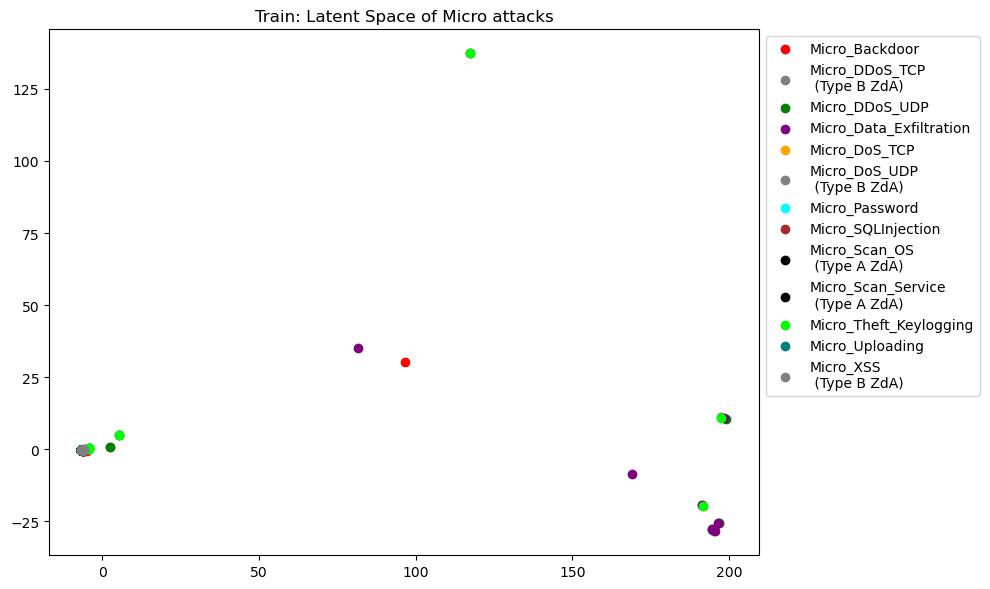

In [9]:
# PLotting a decomposition of the real data feature space:
train_dataset = dm.RealFewShotDataset(
    root_dir=datadir,
    df=train_data)

tensors = []
labels = []

for idx_set in tqdm(train_dataset.idxs_per_micro_class.items()):
    for single_idx in idx_set[1][:50]:
        item = train_dataset[int(single_idx)]
        img = item[0][:512*512].flatten()
        tensors.append(img)
        labels.append(item[1])

tensors = torch.vstack(tensors)
labels = torch.vstack(labels)

pu.plot_hidden_space(
    mod='Train',
    hiddens=tensors,
    labels=labels,
    cat='Micro',
    nl_labels=train_dataset.micro_label_encoder.classes_)

# Training:

## helper code:

In [10]:
def save_stuff(prefix):
    torch.save(
        encoder.state_dict(),
        prefix+'_encoder.pt')
    torch.save(
        decoder_1_b.state_dict(),
        prefix+'_dec_1_b.pt')
    torch.save(
        decoder_2_b.state_dict(),
        prefix+'_dec_2_b.pt')

In [11]:
def first_phase_simple(
        sample_batch):

    global cs_cm_1
    global os_cm_1
    global metrics_dict

    # get masks: THESE ARE NOT COMPLEMETARY!
    zda_mask, \
        known_classes_mask, \
        unknown_1_mask, \
        active_query_mask = utils.get_masks_1(
            sample_batch[1],
            N_QUERY,
            device=device)

    # get one_hot_labels:
    oh_labels = utils.get_oh_labels(
        decimal_labels=sample_batch[1][:, 1].long(),
        total_classes=max_prototype_buffer_micro,
        device=device)

    # mask labels:
    oh_masked_labels = utils.get_one_hot_masked_labels(
        oh_labels,
        unknown_1_mask,
        device=device)

    # encoding input space:
    encoded_inputs = encoder(
        sample_batch[0].float())

    # processing
    decoded_1, hiddens_1, predicted_kernel = processor_1(
        encoded_inputs,
        oh_masked_labels)

    # semantic kernel:
    semantic_kernel = oh_labels @ oh_labels.T
    # Processor regularization:
    proc_1_reg_loss = utils.get_kernel_kernel_loss(
        semantic_kernel,
        predicted_kernel,
        a_w=attr_w,
        r_w=rep_w)

    # Transform lables for Few_shot Closed-set classif.
    # compatible with the design of models.get_centroids functions,
    # wich is called by our GAT processors.
    unique_labels, transformed_labels = sample_batch[1][:, 1][active_query_mask].unique(
        return_inverse=True)

    # closed set classification
    dec_1_loss_a = decoder_1a_criterion(
        decoded_1[active_query_mask],
        transformed_labels)

    # Detach closed from open set gradients
    input_for_os_dec = decoded_1.detach()
    input_for_os_dec.requires_grad = True

    # Unknown cluster prediction:
    predicted_unknown_1s = decoder_1_b(
        scores=input_for_os_dec[unknown_1_mask]
        )

    # open-set loss:
    dec_1_loss_b = decoder_1b_criterion(
        predicted_unknown_1s,
        zda_mask[unknown_1_mask].float().unsqueeze(-1))

    # inverse transform cs preds
    it_preds = utils.inverse_transform_preds(
        transormed_preds=decoded_1[active_query_mask],
        real_labels=unique_labels,
        real_class_num=max_prototype_buffer_micro)

    #
    # REPORTING:
    #

    # Closed set confusion matrix
    cs_cm_1 += utils.efficient_cm(
        preds=it_preds.detach(),
        targets=sample_batch[1][:, 1][active_query_mask].long())

    # Open set confusion matrix
    os_cm_1 += utils.efficient_os_cm(
        preds=(predicted_unknown_1s.detach() > 0.5).long(),
        targets=zda_mask[unknown_1_mask].long()
        )

    # accuracies:
    CS_acc = utils.get_acc(
        logits_preds=it_preds,
        oh_labels=oh_labels[active_query_mask])

    OS_acc = utils.get_binary_acc(
        logits=predicted_unknown_1s.detach(),
        labels=zda_mask[unknown_1_mask].float().unsqueeze(-1))

    OS_b_acc = utils.get_balanced_accuracy(
                os_cm=os_cm_1,
                n_w=balanced_acc_n_w
                )

    # for reporting:
    metrics_dict['losses_1a'].append(dec_1_loss_a.item())
    metrics_dict['proc_reg_loss1'].append(proc_1_reg_loss.item())
    metrics_dict['CS_accuracies'].append(CS_acc.item())
    metrics_dict['losses_1b'].append(dec_1_loss_b.item())
    metrics_dict['OS_accuracies'].append(OS_acc.item())
    metrics_dict['OS_B_accuracies'].append(OS_b_acc.item())

    # Processor loss:
    proc_1_loss = dec_1_loss_a + proc_1_reg_loss

    return proc_1_loss, \
        dec_1_loss_b, \
        hiddens_1, \
        decoded_1

In [12]:
def second_phase_simple(
        sample_batch,
        hiddens_1):

    global cs_cm_2
    global os_cm_2
    global metrics_dict

    # get masks: THESE ARE NOT COMPLEMETARY!
    type_A_mask, known_macro_classes_mask, \
        unknown_2_mask, active_query_mask_2 = utils.get_masks_2(
            sample_batch[1],
            N_QUERY,
            device=device)

    # get one_hot_labels:
    oh_labels = utils.get_oh_labels(
        decimal_labels=sample_batch[1][:, 0].long(),
        total_classes=max_prototype_buffer_macro,
        device=device)

    # mask labels:
    oh_masked_labels = utils.get_one_hot_masked_labels(
        oh_labels,
        unknown_2_mask,
        device=device)

    decoded_2, hiddens_2, predicted_kernel_2 = processor_2(
        hiddens_1,
        oh_masked_labels)

    # semantic kernel:
    semantic_kernel_2 = oh_labels @ oh_labels.T
    # Processor regularization:
    proc_2_reg_loss = utils.get_kernel_kernel_loss(
        semantic_kernel_2,
        predicted_kernel_2,
        a_w=attr_w,
        r_w=rep_w)

    unique_macro_labels, transformed_labels_2 = sample_batch[1][:, 0][active_query_mask_2].unique(
        return_inverse=True)

    # Closed set: should learn to associate type B's to corr. macro cluster.
    # geometrical "break" in the real-data case. (GRadients 2A)
    dec_2_loss_a = decoder_2a_criterion(
        decoded_2[active_query_mask_2],
        transformed_labels_2)

    input_for_os_dec_2 = decoded_2.detach()
    input_for_os_dec_2.requires_grad = True

    # Unknown cluster prediction:
    predicted_unknown_2s = decoder_2_b(
        scores=input_for_os_dec_2[unknown_2_mask]
        )

    # open-set loss:
    dec_2_loss_b = decoder_2b_criterion(
        predicted_unknown_2s,
        type_A_mask[unknown_2_mask].float().unsqueeze(-1))

    # inverse transform cs preds
    it_preds = utils.inverse_transform_preds(
        transormed_preds=decoded_2[active_query_mask_2],
        real_labels=unique_macro_labels,
        real_class_num=max_prototype_buffer_macro)

    # Closed set confusion matrix
    cs_cm_2 += utils.efficient_cm(
        preds=it_preds.detach(),
        targets=sample_batch[1][:, 0][active_query_mask_2].long(),
        )

    # Open set confusion matrix
    os_cm_2 += utils.efficient_os_cm(
        preds=(predicted_unknown_2s.detach() > 0.5).long(),
        targets=type_A_mask[unknown_2_mask].long()
        )

    # accuracies:
    CS_acc_2 = utils.get_acc(
        logits_preds=it_preds,
        oh_labels=oh_labels[active_query_mask_2])

    OS_acc_2 = utils.get_binary_acc(
        logits=predicted_unknown_2s.detach(),
        labels=type_A_mask[unknown_2_mask].float().unsqueeze(-1))

    OS_2_B_acc = utils.get_balanced_accuracy(
                os_cm=os_cm_2,
                n_w=balanced_acc_n_w
                )

    proc_2_loss = dec_2_loss_a + proc_2_reg_loss

    # for reporting:
    metrics_dict['losses_2a'].append(dec_2_loss_a.item())
    metrics_dict['proc_reg_loss2'].append(proc_2_reg_loss.item())
    metrics_dict['losses_2b'].append(dec_2_loss_b.item())
    metrics_dict['CS_2_accuracies'].append(CS_acc_2.item())
    metrics_dict['OS_2_accuracies'].append(OS_acc_2.item())
    metrics_dict['OS_2_B_accuracies'].append(OS_2_B_acc.item())

    return proc_2_loss, \
        dec_2_loss_b, \
        hiddens_2, \
        decoded_2

## init data:

In [15]:
"""
# Set the maximum number of records you want for each Micro Label
max_records = 5000


# Function to select the top N records for each group
def select_top_n(group):
    return group.head(max_records)


# Apply the function to each group and concatenate the results into a new DataFrame
reduced_train_data = train_data.groupby('Micro Label', group_keys=False).apply(select_top_n)

# Reset index if needed
reduced_train_data = reduced_train_data.reset_index(drop=True)

reduced_train_data.to_csv(f'reduced_train_data_{max_records}.csv', index=False)
"""

reduced_train_data = pd.read_csv('reduced_data_mappings/reduced_train_data_1000.csv')

In [16]:
save = False
wb = False

In [17]:
# Generate Data
torch_seed = 1234
torch.manual_seed(torch_seed)


#
#
# Initialize
#
#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and Dataloader:
train_dataset = dm.RealFewShotDataset(
    root_dir=datadir,
    df=reduced_train_data)

test_dataset = dm.RealFewShotDataset(
    root_dir=datadir,
    df=test_data)

# Number of classes per task :
# two of them are ZdAs, one is a type B and the other a type A
N_WAY = 4
N_SHOT = 5   # Number of samples per class in the support set
N_QUERY = 50  # Number of samples per class in the query set

n_train_tasks = 100    # For speedy tests, reduce here...
n_eval_tasks = 20     # For speedy tests, reduce here...


num_of_test_classes = len(test_dataset.micro_classes)
num_of_train_classes = len(train_dataset.micro_classes)

train_loader = DataLoader(
    dataset=train_dataset,
    sampler=dm.FewShotSamplerReal(
                dataset=train_dataset,
                n_tasks=n_train_tasks,
                classes_per_it=N_WAY,
                k_shot=N_SHOT,
                q_shot=N_QUERY),
    num_workers=10,
    drop_last=True,
    collate_fn=dm.convenient_cf)

test_loader = DataLoader(
    dataset=test_dataset,
    sampler=dm.FewShotSamplerReal(
                dataset=test_dataset,
                n_tasks=n_eval_tasks,
                classes_per_it=N_WAY,
                k_shot=N_SHOT,
                q_shot=N_QUERY),
    num_workers=10,
    drop_last=True,
    collate_fn=dm.convenient_cf)

# reproducibility
train_loader.sampler.reset()
test_loader.sampler.reset()

## init architectures:

In [18]:
###
# Hyper params:
###
max_prototype_buffer_micro = 17
max_prototype_buffer_macro = 7
lr = 0.001
# training parameters
n_epochs = 120
norm = "batch"
dropout = 0.1
patience = 40
lambda_os = 1

processor_attention_heads = 8
h_dim = 1024
report_step_frequency = 10
colaborative_GAT = "True by def"
pos_weight_1 = 1
pos_weight_2 = 3
architectures = 'GATV5 Confidence Dec'
balanced_acc_n_w = 0.5
attr_w = 1
rep_w = 1
natural_inputs_dim = "NA"
run_name = f'suffling_FT_H{h_dim}'

if wb:
    wandb.init(project='NAR_for_ZdA',
               name=run_name,
               config={"N_SHOT": N_SHOT,
                       "N_QUERY": N_QUERY,
                       "num_of_test_classes": num_of_test_classes,
                       "num_of_train_classes": num_of_train_classes,
                       "train_batch_size": iter(train_loader).__next__()[0].shape[1],
                       "len(train_loader)": len(train_loader),
                       "len(test_dataset)": len(test_dataset),
                       "max_prototype_buffer_micro": max_prototype_buffer_micro,
                       "max_prototype_buffer_macro": max_prototype_buffer_macro,
                       "device": device,
                       "natural_inputs_dim": natural_inputs_dim,
                       "h_dim": h_dim,
                       "lr": lr,
                       "n_epochs": n_epochs,
                       "norm": norm,
                       "dropout": dropout,
                       "patience": patience,
                       'micro_zdas': data[data.ZdA == True]['Micro Label'].unique(),
                       'micro_type_A_ZdAs': data[data.Type_A_ZdA == True]['Micro Label'].unique(),
                       'micro_type_B_ZdAs': data[data.Type_B_ZdA == True]['Micro Label'].unique(),
                       "lambda_os": lambda_os,
                       "colaborative_GAT": colaborative_GAT,
                       "positive_weight_1": pos_weight_1,
                       "positive_weight_2": pos_weight_2,
                       "architectures": architectures,
                       "balanced_acc_n_w": balanced_acc_n_w,
                       "attr_w": attr_w,
                       "rep_w": rep_w
                       })
else:
    print(run_name)

# Encoder
encoder = resnet18().to(device)
encoder.fc = nn.Sequential(nn.Flatten(),
                           nn.Linear(512,
                                     h_dim)).to(device)

# First phase:
processor_1 = models.GAT_V5_Processor(
                h_dim=h_dim,
                processor_attention_heads=processor_attention_heads,
                dropout=dropout,
                device=device
                ).to(device)

decoder_1a_criterion = nn.CrossEntropyLoss()

decoder_1_b = models.Confidence_Decoder(
                in_dim=N_WAY-2, # Subtrack a type A and a type B ZdA attack
                dropout=dropout,
                device=device
                ).to(device)

decoder_1b_criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.Tensor([pos_weight_1])).to(device)

# Second phase:
processor_2 = models.GAT_V5_Processor(
                h_dim=h_dim,
                processor_attention_heads=processor_attention_heads,
                dropout=dropout,
                device=device
                ).to(device)

decoder_2a_criterion = nn.CrossEntropyLoss().to(device)

decoder_2_b = models.Confidence_Decoder(
                in_dim=N_WAY-1, # Only type A attack will be discarded from known realm
                dropout=dropout,
                device=device
                ).to(device)

decoder_2b_criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.Tensor([pos_weight_2])).to(device)


params_for_processor_optimizer = \
        list(encoder.parameters()) + \
        list(processor_1.parameters()) + \
        list(processor_2.parameters())

processor_optimizer = optim.Adam(
    params_for_processor_optimizer,
    lr=lr)

params_for_os_optimizer = \
        list(decoder_1_b.parameters()) + \
        list(decoder_2_b.parameters())

os_optimizer = optim.Adam(
    params_for_os_optimizer,
    lr=lr)


# TRAINING
max_eval_TNR = torch.zeros(1, device=device)
epochs_without_improvement = 0

suffling_FT_H1024


In [ ]:
wandb.watch(processor_1)
wandb.watch(processor_2)
wandb.watch(encoder)
wandb.watch(decoder_1_b)
wandb.watch(decoder_2_b)

## Train (from scratch):

In [ ]:
for epoch in tqdm(range(n_epochs)):

    # TRAIN
    encoder.train()
    processor_1.train()
    decoder_1_b.train()
    processor_2.train()
    decoder_2_b.train()

    # reset conf Mats
    cs_cm_1 = torch.zeros(
        [max_prototype_buffer_micro, max_prototype_buffer_micro],
        device=device)
    os_cm_1 = torch.zeros([2, 2], device=device)
    cs_cm_2 = torch.zeros(
        [max_prototype_buffer_macro, max_prototype_buffer_macro],
        device=device)
    os_cm_2 = torch.zeros([2, 2], device=device)

    # reset metrics dict
    metrics_dict = utils.reset_metrics_dict()

    # go!
    for batch_idx, sample_batch in enumerate(train_loader):
        # go to cuda:
        sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)

        # PHASE 1
        proc_1_loss, \
            os_1_loss, \
            hiddens_1, \
            decoded_1 = first_phase_simple(
                                sample_batch)

        # PHASE 2
        proc_2_loss, \
            os_2_loss, \
            hiddens_2, \
            decoded_2 = second_phase_simple(
                sample_batch,
                hiddens_1)

        # Learning
        proc_loss = proc_1_loss + proc_2_loss
        processor_optimizer.zero_grad()
        proc_loss.backward()
        processor_optimizer.step()

        os_loss = os_1_loss + os_2_loss
        os_optimizer.zero_grad()
        os_loss.backward()
        os_optimizer.step()

        # Reporting
        step = batch_idx + (epoch * train_loader.sampler.n_tasks)

        if step % report_step_frequency == 0:
            utils.reporting_simple(
                'train',
                epoch,
                metrics_dict,
                step,
                wb,
                wandb)

    pu.super_plotting_function(
                phase='Training',
                labels=sample_batch[1].cpu(),
                hiddens_1=hiddens_1.detach().cpu(),
                hiddens_2=hiddens_2.detach().cpu(),
                scores_1=decoded_1.detach().cpu(),
                scores_2=decoded_2.detach().cpu(),
                cs_cm_1=cs_cm_1.cpu(),
                cs_cm_2=cs_cm_2.cpu(),
                os_cm_1=os_cm_1.cpu(),
                os_cm_2=os_cm_2.cpu(),
                wb=wb,
                wandb=wandb,
                complete_micro_classes=micro_classes,
                complete_macro_classes=macro_classes
                )

    with torch.inference_mode():

        # Evaluation
        encoder.eval()
        processor_1.eval()
        decoder_1_b.eval()
        processor_2.eval()
        decoder_2_b.eval()

        # reset conf Mats
        cs_cm_1 = torch.zeros(
            [max_prototype_buffer_micro, max_prototype_buffer_micro],
            device=device)
        os_cm_1 = torch.zeros([2, 2], device=device)
        cs_cm_2 = torch.zeros(
            [max_prototype_buffer_macro, max_prototype_buffer_macro],
            device=device)
        os_cm_2 = torch.zeros([2, 2], device=device)

        # reset metrics dict
        metrics_dict = utils.reset_metrics_dict()

        # go!
        for batch_idx, sample_batch in enumerate(test_loader):
            # go to cuda:
            sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)

            # PHASE 1
            proc_1_loss, \
                os_1_loss, \
                hiddens_1, \
                decoded_1 = first_phase_simple(
                                    sample_batch)

            # PHASE 2
            proc_2_loss, \
                os_2_loss, \
                hiddens_2, \
                decoded_2 = second_phase_simple(
                    sample_batch,
                    hiddens_1)

            # Reporting
            step = batch_idx + (epoch * test_loader.sampler.n_tasks)

            if step % report_step_frequency == 0:
                utils.reporting_simple(
                    'eval',
                    epoch,
                    metrics_dict,
                    step,
                    wb,
                    wandb)

        pu.super_plotting_function(
                phase='Evaluation',
                labels=sample_batch[1].cpu(),
                hiddens_1=hiddens_1.detach().cpu(),
                hiddens_2=hiddens_2.detach().cpu(),
                scores_1=decoded_1.detach().cpu(),
                scores_2=decoded_2.detach().cpu(),
                cs_cm_1=cs_cm_1.cpu(),
                cs_cm_2=cs_cm_2.cpu(),
                os_cm_1=os_cm_1.cpu(),
                os_cm_2=os_cm_2.cpu(),
                wb=wb,
                wandb=wandb,
                complete_micro_classes=micro_classes,
                complete_macro_classes=macro_classes
            )

        # Checking for improvement
        curr_TNR = np.array(metrics_dict['OS_2_B_accuracies']).mean()

        if curr_TNR > max_eval_TNR:
            max_eval_TNR = curr_TNR
            epochs_without_improvement = 0
            save_stuff(run_name)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping at step {step}')
            if wb:
                wandb.log({'Early stopping at step': step})
            break

if wb:
    wandb.finish()

In [ ]:
wandb.finish()

## Train (fine tune a pre-trained Neural algorithmic processor):

In [28]:
models_dir =  "../../nfs/jcevallos/models_project_1/NAR_for_ZdA/"

In [29]:
processor_1.load_state_dict(torch.load(models_dir+'SufflePretrain_H1024_proc_1.pt'))
processor_2.load_state_dict(torch.load(models_dir+'SufflePretrain_H1024_proc_2.pt'))
processor_1.eval()
processor_2.eval()

# Freeze the pre-trained processor
for param in processor_1.parameters():
    param.requires_grad = False
# Freeze the pre-trained processor
for param in processor_2.parameters():
    param.requires_grad = False

In [ ]:
for epoch in tqdm(range(n_epochs)):

    # TRAIN
    encoder.train()
    decoder_1_b.train()
    decoder_2_b.train()

    # reset conf Mats
    cs_cm_1 = torch.zeros(
        [max_prototype_buffer_micro, max_prototype_buffer_micro],
        device=device)
    os_cm_1 = torch.zeros([2, 2], device=device)
    cs_cm_2 = torch.zeros(
        [max_prototype_buffer_macro, max_prototype_buffer_macro],
        device=device)
    os_cm_2 = torch.zeros([2, 2], device=device)

    # reset metrics dict
    metrics_dict = utils.reset_metrics_dict()

    # go!
    for batch_idx, sample_batch in enumerate(train_loader):
        # go to cuda:
        sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)

        # PHASE 1
        proc_1_loss, \
            os_1_loss, \
            hiddens_1, \
            decoded_1 = first_phase_simple(
                                sample_batch)

        # PHASE 2
        proc_2_loss, \
            os_2_loss, \
            hiddens_2, \
            decoded_2 = second_phase_simple(
                sample_batch,
                hiddens_1)

        # Learning
        proc_loss = proc_1_loss + proc_2_loss
        processor_optimizer.zero_grad()
        proc_loss.backward()
        processor_optimizer.step()

        os_loss = os_1_loss + os_2_loss
        os_optimizer.zero_grad()
        os_loss.backward()
        os_optimizer.step()

        # Reporting
        step = batch_idx + (epoch * train_loader.sampler.n_tasks)

        if step % report_step_frequency == 0:
            utils.reporting_simple(
                'train',
                epoch,
                metrics_dict,
                step,
                wb,
                wandb)

    pu.super_plotting_function(
                phase='Training',
                labels=sample_batch[1].cpu(),
                hiddens_1=hiddens_1.detach().cpu(),
                hiddens_2=hiddens_2.detach().cpu(),
                scores_1=decoded_1.detach().cpu(),
                scores_2=decoded_2.detach().cpu(),
                cs_cm_1=cs_cm_1.cpu(),
                cs_cm_2=cs_cm_2.cpu(),
                os_cm_1=os_cm_1.cpu(),
                os_cm_2=os_cm_2.cpu(),
                wb=wb,
                wandb=wandb,
                complete_micro_classes=micro_classes,
                complete_macro_classes=macro_classes
                )

    with torch.inference_mode():

        # Evaluation
        encoder.eval()
        decoder_1_b.eval()
        decoder_2_b.eval()

        # reset conf Mats
        cs_cm_1 = torch.zeros(
            [max_prototype_buffer_micro, max_prototype_buffer_micro],
            device=device)
        os_cm_1 = torch.zeros([2, 2], device=device)
        cs_cm_2 = torch.zeros(
            [max_prototype_buffer_macro, max_prototype_buffer_macro],
            device=device)
        os_cm_2 = torch.zeros([2, 2], device=device)

        # reset metrics dict
        metrics_dict = utils.reset_metrics_dict()

        # go!
        for batch_idx, sample_batch in enumerate(test_loader):
            # go to cuda:
            sample_batch = sample_batch[0].to(device), sample_batch[1].to(device)

            # PHASE 1
            proc_1_loss, \
                os_1_loss, \
                hiddens_1, \
                decoded_1 = first_phase_simple(
                                    sample_batch)

            # PHASE 2
            proc_2_loss, \
                os_2_loss, \
                hiddens_2, \
                decoded_2 = second_phase_simple(
                    sample_batch,
                    hiddens_1)

            # Reporting
            step = batch_idx + (epoch * test_loader.sampler.n_tasks)

            if step % report_step_frequency == 0:
                utils.reporting_simple(
                    'eval',
                    epoch,
                    metrics_dict,
                    step,
                    wb,
                    wandb)

        pu.super_plotting_function(
                phase='Evaluation',
                labels=sample_batch[1].cpu(),
                hiddens_1=hiddens_1.detach().cpu(),
                hiddens_2=hiddens_2.detach().cpu(),
                scores_1=decoded_1.detach().cpu(),
                scores_2=decoded_2.detach().cpu(),
                cs_cm_1=cs_cm_1.cpu(),
                cs_cm_2=cs_cm_2.cpu(),
                os_cm_1=os_cm_1.cpu(),
                os_cm_2=os_cm_2.cpu(),
                wb=wb,
                wandb=wandb,
                complete_micro_classes=micro_classes,
                complete_macro_classes=macro_classes
            )

        # Checking for improvement
        curr_TNR = np.array(metrics_dict['OS_2_B_accuracies']).mean()

        if curr_TNR > max_eval_TNR:
            max_eval_TNR = curr_TNR
            epochs_without_improvement = 0
            save_stuff(run_name)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping at episode {step}')
            if wb:
                wandb.log({'Early stopping at step': step})
            break

print(f'max_eval_TNR: {max_eval_TNR}')
if wb:
    wandb.finish()

In [ ]:
wandb.finish()